In [89]:
!pwd

/media/atem/Data/HSE_videos/4_DLA


In [90]:
%cd ../..

/media/atem/Data


In [91]:
import random

## Test Dataset

In [92]:
from omegaconf import OmegaConf
from hydra.utils import instantiate
from hydra import initialize, compose

with initialize(config_path="../configs", version_base=None):
    cfg = compose(config_name="baseline.yaml")
    dataset = instantiate(cfg.datasets.train, reindex=False, video_dir="/home/atem/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/mouths")

In [93]:
import random
import torch
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

def plot_spec_and_phase(magnitude, phase, title_prefix=""):
    """Визуализация спектрограммы и фазы рядом"""
    mag = magnitude.squeeze().cpu().numpy()
    phs = phase.squeeze().cpu().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(10, 3))
    im0 = axes[0].imshow(20 * np.log10(mag + 1e-8), aspect='auto', origin='lower')
    axes[0].set_title(f"{title_prefix} Magnitude (dB)")
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    im1 = axes[1].imshow(phs, aspect='auto', origin='lower', cmap='twilight')
    axes[1].set_title(f"{title_prefix} Phase")
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()
    plt.show()


def listen_samples(dataset, k=3, sample_rate=16000):
    """
    Случайно выбирает k примеров из датасета и показывает:
      - аудио original mix
      - аудио mix после аугментаций
      - спектрограмму и фазу mix
      - аудио source 1 + его спектр и фазу
      - аудио source 2 + его спектр и фазу
    """
    indices = random.sample(range(len(dataset)), k)
    print(f"🎧 Прослушиваем {k} случайных примеров: {indices}\n")

    for idx in indices:
        example = dataset[idx]

        mix_orig = example["audio_original"].squeeze().cpu()
        mix_aug = example["audio"].squeeze().cpu()
        mix_mag = example["spectrogram"].squeeze().cpu()
        mix_phase = example["phase"].squeeze().cpu()

        src1_dict = example["sources"][0]
        src2_dict = example["sources"][1]

        src1_audio = src1_dict[list(src1_dict.keys())[0]].squeeze().cpu()
        src1_mag = src1_dict[list(src1_dict.keys())[1]].squeeze().cpu()
        src1_phase = src1_dict[list(src1_dict.keys())[2]].squeeze().cpu()

        src2_audio = src2_dict[list(src2_dict.keys())[0]].squeeze().cpu()
        src2_mag = src2_dict[list(src2_dict.keys())[1]].squeeze().cpu()
        src2_phase = src2_dict[list(src2_dict.keys())[2]].squeeze().cpu()

        print(f"🔹 Sample #{idx}")

        # --- MIX ORIGINAL ---
        print("🎧 Original Mix:")
        display(ipd.Audio(mix_orig.numpy(), rate=sample_rate))

        # --- MIX AUGMENTED ---
        print("🎧 Augmented Mix:")
        display(ipd.Audio(mix_aug.numpy(), rate=sample_rate))

        print("📊 Mix Spectrogram & Phase:")
        plot_spec_and_phase(mix_mag, mix_phase, "Mix")

        # --- SOURCE 1 ---
        print("🎧 Source 1:")
        display(ipd.Audio(src1_audio.numpy(), rate=sample_rate))
        print("📊 Source 1 Spectrogram & Phase:")
        plot_spec_and_phase(src1_mag, src1_phase, "Source 1")

        # --- SOURCE 2 ---
        print("🎧 Source 2:")
        display(ipd.Audio(src2_audio.numpy(), rate=sample_rate))
        print("📊 Source 2 Spectrogram & Phase:")
        plot_spec_and_phase(src2_mag, src2_phase, "Source 2")

        print("-" * 100)


🎧 Прослушиваем 2 случайных примеров: [705, 2931]

🔹 Sample #705
🎧 Original Mix:


🎧 Augmented Mix:


📊 Mix Spectrogram & Phase:


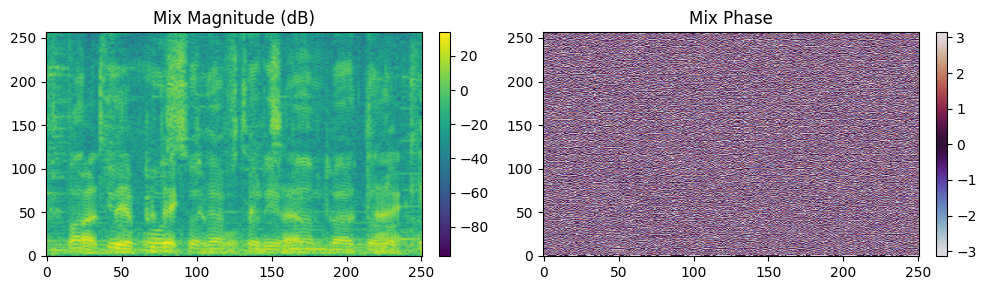

🎧 Source 1:


📊 Source 1 Spectrogram & Phase:


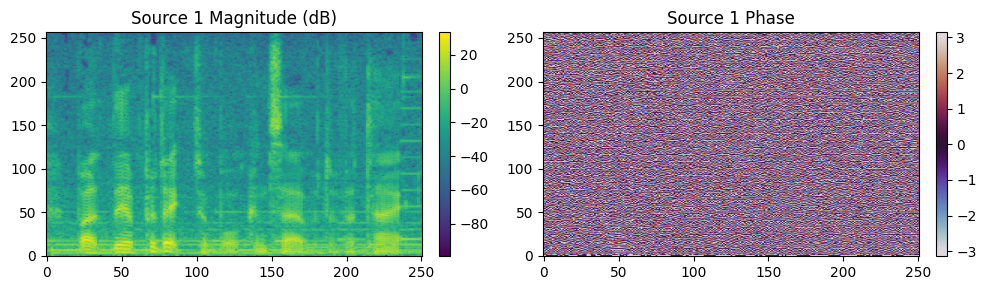

🎧 Source 2:


📊 Source 2 Spectrogram & Phase:


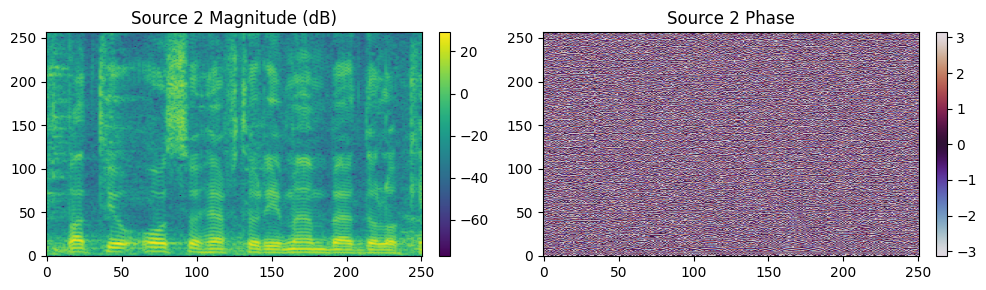

----------------------------------------------------------------------------------------------------
🔹 Sample #2931
🎧 Original Mix:


🎧 Augmented Mix:


📊 Mix Spectrogram & Phase:


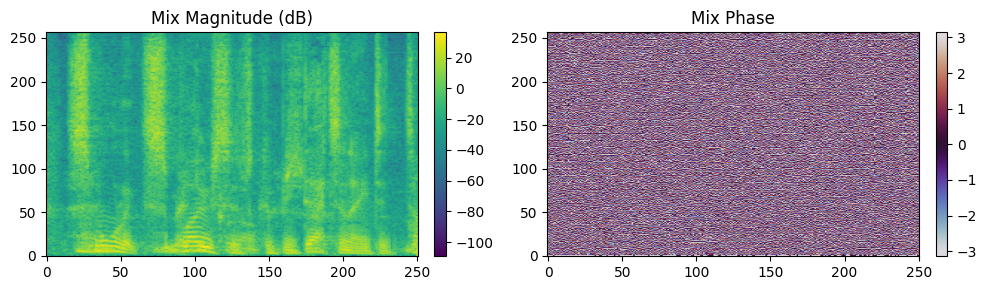

🎧 Source 1:


📊 Source 1 Spectrogram & Phase:


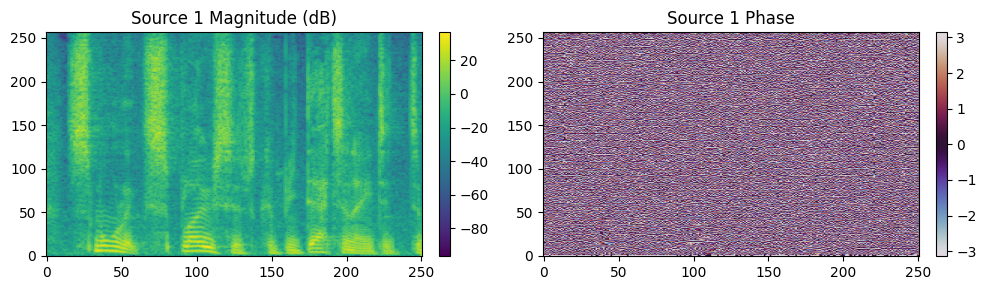

🎧 Source 2:


📊 Source 2 Spectrogram & Phase:


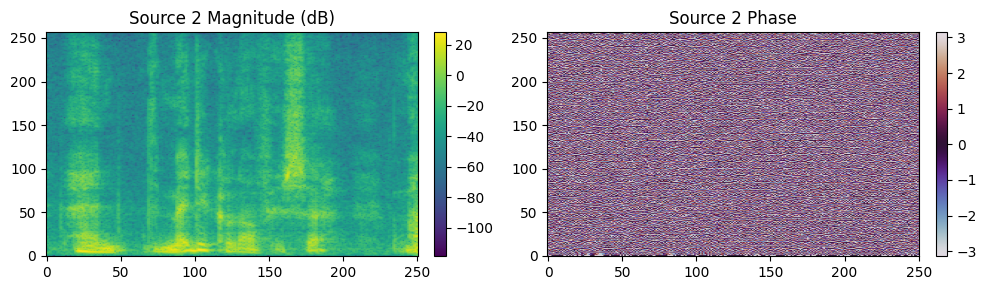

----------------------------------------------------------------------------------------------------


In [94]:
listen_samples(dataset, k=2, sample_rate=dataset.target_sr)

## Test vidoe .npz files

In [95]:
import numpy as np
npz = np.load("/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/mouths/00000083568.npz")

In [96]:
npz["data"].shape

(50, 96, 96)

## Test collate_fn

In [97]:
%load_ext autoreload
%autoreload 2

from src.datasets.collate import collate_fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import random
k = 10
indices = random.sample(range(len(dataset)), k)
examples = [dataset[idx] for idx in indices]

In [99]:
len(examples)

10

In [136]:
examples[0]["sources"][1]["video"].shape

(50, 96, 96)

In [ ]:
torch.stack([torch.stack([torch.tensor(item["sources"][source_idx]["video"]) for source_idx in range(2)]) for item in examples])

torch.Size([10, 2, 50, 96, 96])

In [101]:
examples[0]["audio"].shape, examples[1]["audio"].shape

(torch.Size([1, 32000]), torch.Size([1, 32000]))

In [145]:
batch = collate_fn(examples)

In [146]:
batch.keys()

dict_keys(['spectrogram', 'phase', 'spectrogram_length', 'audio', 'video', 'audio_lengths', 'sources', 'audio_original', 'audio_path', 'audio_length'])

In [104]:
batch['audio_path']

['/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/audio/val/mix/00776212389_00471485711.wav',
 '/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/audio/val/mix/00163711186_00253908553.wav',
 '/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/audio/val/mix/00964811172_00142758537.wav',
 '/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/audio/val/mix/00897976470_00921795935.wav',
 '/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/audio/val/mix/00854372962_00537457416.wav',
 '/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/audio/val/mix/00243371379_00423650585.wav',
 '/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/audio/val/mix/00344272360_00743153519.wav',
 '/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/audio/val/mix/00554115108_00409206126.wav',
 '/media/atem/Data/HSE_videos/4_DLA/hw_2_SeppechSep/dla_dataset/audio/val/mix/00605387592_00038345074.wav',
 '/media/atem/Data/HSE_video

In [147]:
batch['spectrogram'].shape, batch['spectrogram_length'], batch['audio_length']

(torch.Size([10, 257, 251]),
 tensor([251, 251, 251, 251, 251, 251, 251, 251, 251, 251]),
 32000)

In [106]:
batch['audio'].shape, batch['audio_length']

(torch.Size([10, 32000]), 32000)

In [107]:
len(batch['sources'])

2

In [108]:
batch['sources'][0].keys()

dict_keys(['audio', 'spectrogram', 'phase', 'video'])

In [109]:
batch['sources'][0]["spectrogram"].shape

torch.Size([10, 257, 251])

In [148]:
batch['sources'][0]["audio"].device

device(type='cpu')

In [152]:
batch["video"].shape

torch.Size([10, 2, 50, 96, 96])

## Test Batch to Device

In [112]:
import torch
def move_batch_to_device(device, batch):
    """
    Move all necessary tensors to the device.

    Args:
        batch (dict): dict-based batch containing the data from
            the dataloader.
    Returns:
        batch (dict): dict-based batch containing the data from
            the dataloader with some of the tensors on the device.
    """
    for tensor_for_device in ["spectrogram", "phase", "sources", "audio", "audio_length"]:
        if isinstance(batch[tensor_for_device], torch.Tensor):
            batch[tensor_for_device] = batch[tensor_for_device].to(device)
        if isinstance(batch[tensor_for_device], list):
            for item in batch[tensor_for_device]:
                if isinstance(item, torch.Tensor):
                    item = item.to(device)
                if isinstance(item, dict):
                    for k, v in item.items():
                        item[k] = v.to(device)
    return batch

In [113]:
device = 'cuda'

In [114]:
batch = move_batch_to_device(device, batch)

In [115]:
batch["sources"][0]["spectrogram"].device

device(type='cuda', index=0)

In [116]:
batch["sources"][0]["video"].device

device(type='cuda', index=0)

## Test Baseline Model

In [117]:
from src.model import BaselineModel

In [118]:
baseline_model = BaselineModel(n_feats=257)
baseline_model.to(device)

BaselineModel(
  (source_nets): ModuleList(
    (0-1): 2 x BaselineModelBlock(
      (net_spec): Sequential(
        (0): Linear(in_features=257, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=257, bias=True)
      )
      (net_phase): Sequential(
        (0): Linear(in_features=257, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=257, bias=True)
      )
    )
  )
)

In [119]:
model_out = baseline_model(**batch)
batch.update(model_out)


In [120]:
batch.keys()

dict_keys(['spectrogram', 'phase', 'spectrogram_length', 'audio', 'audio_length', 'sources', 'audio_original', 'audio_path', 'preds'])

In [121]:
batch["spectrogram"].shape

torch.Size([10, 257, 251])

## Test Loss

In [122]:
from src.loss import DTTNetLoss
spec_loss = DTTNetLoss()

In [123]:
loss_spectrum = spec_loss(
    audio_pred = batch["preds"][0]["audio"], 
    spectrogram_pred = batch["preds"][0]["spectrogram"], 
    phase_pred = batch["preds"][0]["phase"],
    audio_true = batch["sources"][0]["audio"], 
    spectrogram_true = batch["sources"][0]["spectrogram"], 
    phase_true = batch["sources"][0]["phase"], 
)

In [124]:
loss_spectrum

tensor([2.7680, 3.0650, 3.1099, 2.4599, 2.9044, 3.2182, 2.6618, 2.4899, 2.7126,
        3.0205], device='cuda:0', grad_fn=<AddBackward0>)

## Test PIT Loss Wrapper

In [125]:
# from src.loss.pit_loss_wrapper import PITLossWrapper
with initialize(config_path="../configs", version_base=None):
    cfg = compose(config_name="baseline.yaml")
    pit_loss = instantiate(cfg.loss_function)

In [126]:
loss = pit_loss(**batch)
loss

{'loss': tensor(5.6575, device='cuda:0', grad_fn=<MeanBackward0>),
 'batch_permuts': tensor([[1, 0],
         [0, 1],
         [0, 1],
         [1, 0],
         [0, 1],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0],
         [1, 0]], device='cuda:0')}

In [127]:
batch.update(loss)

In [128]:
batch.keys()

dict_keys(['spectrogram', 'phase', 'spectrogram_length', 'audio', 'audio_length', 'sources', 'audio_original', 'audio_path', 'preds', 'loss', 'batch_permuts'])

In [129]:
batch["preds"][0]["audio"].shape

torch.Size([10, 32000])

## Test Metrics

In [130]:
from src.metrics.si_snr_i_PIT_wrapper import SiSnrIPITWrapper
from src.metrics.si_snr_i import SiSnrI
from src.metrics.si_snr import SiSnr

In [131]:
si_snr = SiSnr()

In [132]:
pred_audio_batch = batch['preds'][0]['audio']
true_audio_batch = batch['sources'][0]['audio']
si_snr(pred_audio_batch, true_audio_batch)

tensor([-19.6173, -42.8138, -22.6513, -20.5510, -45.0757, -31.6965, -52.3708,
        -43.0712, -23.5943, -28.2008], device='cuda:0', grad_fn=<MulBackward0>)

In [133]:
metric_wrapper = SiSnrIPITWrapper()

In [134]:
metric_wrapper(**batch)

tensor(-69.6527)